# Overview

The data has been split into two groups:
training set (train.csv)
test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

## Variable Information

survival - 	Survival	0 = No, 1 = Yes

pclass - 	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd. A proxy for socio-economic status (SES) 1st = Upper 2nd = Middle 3rd = Lower

sex - 	Sex	

Age - 	Age in years.	Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp - 	# of siblings / spouses aboard the Titanic.	The dataset defines family relations in this way... Sibling = brother, sister, stepbrother, stepsister Spouse = husband, wife (mistresses and fiancés were ignored)

parch - 	# of parents / children aboard the Titanic.	The dataset defines family relations in this way... Parent = mother, father Child = daughter, son, stepdaughter, stepson Some children travelled only with a nanny, therefore parch=0 for them.

ticket - 	Ticket number	

fare - 	Passenger fare	

cabin - 	Cabin number	

embarked - 	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

### Reading Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Train Size:", train.shape)
print("Test Size:", test.shape)

Train Size: (891, 12)
Test Size: (418, 11)


##### Combining Test and Training Data for analysis and preprocessing

In [3]:
combined = [train, test]
display(train.head())
print("Train Shape:", train.shape)
print('Test Shape:', test.shape)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Train Shape: (891, 12)
Test Shape: (418, 11)


###### Features:
Categorical: Survived, Sex, and Embarked. 

Ordinal: Pclass

Continous: Age, Fare. 

Discrete: SibSp, Parch.

### Exploratory Data Analysis

In [4]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [5]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


###### Missing Values
Cabin > Age > Embarked features contain a number of null values in that order for the training dataset.

Cabin > Age > Fare are incomplete in case of test dataset.

###### Datatypes
Seven features are integer or floats. Six in case of test dataset.

Five features are strings (object).

In [6]:
display(train.describe())

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


###### Observations:
- Survived is a categorical column with values 0 and 1
- Most of the passenger were travelling without any parents or children
- Around 25-30% of people were travelling with spouse or siblings on board
- Most of the passengers are young. Around 75% passengers are under 40.
- Around 75% of the passengers paid a fare below 50 while some paid quite a high fare of upto 512.

In [7]:
display(train.describe(include=['O']))

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Silven, Miss. Lyyli Karoliina",male,1601,B96 B98,S
freq,1,577,7,4,644


- Lot of missing values in Cabin column. Cabin is an alphanumeric value. Some values are duplicate. It could be possible that some people shared the same cabin.
- Names are unique
- Most of the people embarked from Southampton.
- Males are more in number as compared to females.

In [8]:
cat_cols = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp']
con_cols = ['Age', 'Fare']
target = 'Survived'

#### Visualising Target Column - Survived

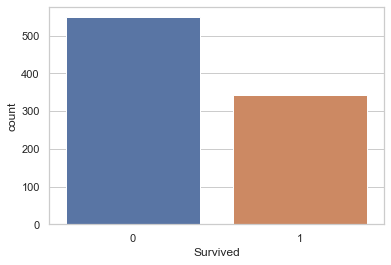

In [9]:
sns.countplot(train['Survived'])
plt.show()

- More than 500 people did not survive.

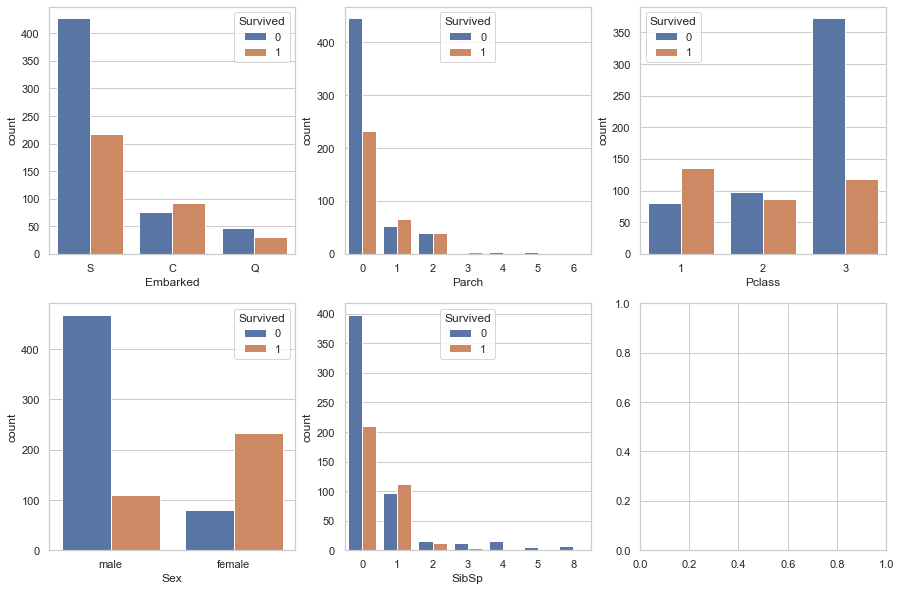

In [10]:
fig, axes = plt.subplots(2, 3, figsize = (15, 10))
axes = axes.flatten()
for i in range(len(cat_cols)):    
    sns.countplot(cat_cols[i], hue = target, data = train, ax = axes[i])

###### Observations:
- Most of the people who died embarked from Southampton
- Most of the people who died were travelling alone i.e. without any parents, children,siblings or spouse.
- Death rate of people having Pclass 3 is quite more as compared to other Pclass. This indicates that upper class people were given preference in evacuation.
- Males have a higher death rate than females indicating females were given preference in evacuation.

#### Visualising Age Distribution

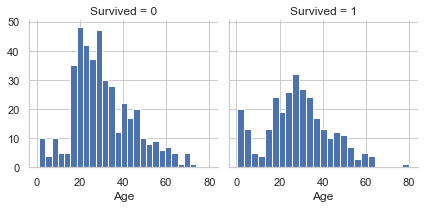

In [11]:
g = sns.FacetGrid(train, col = 'Survived')
g.map(plt.hist, 'Age', bins = 25)
plt.show()

##### Observations:
- Infants' (0-5 years) survival rate is higher than that of young adults (which most of them are travelling single)
- People aged 65- 75 did not survive. While,the oldest passenger with age = 80 years survived.
- Most of the people died were between 17 - 34 years old.
- We should band the ages to create different groups. This will help our analysis

#### Visualising Age Distribution Across Different Pclass with respect to Survival

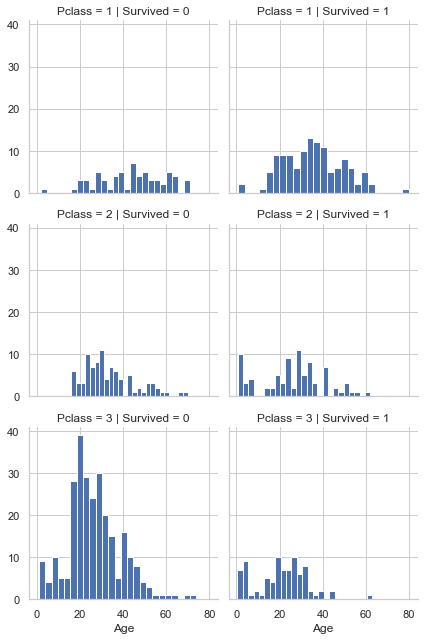

In [12]:
grid = sns.FacetGrid(train, col = 'Survived', row = 'Pclass')
grid.map(plt.hist, 'Age', bins = 25)
plt.show()

###### Observations:
- Most of the passengers in Pclass 1 Survived.
- Infants' in Pclass 2 and 3 survived with a single exception in Pclass 3. In Pclass 1, surival rate of infants is higher than others. But compared to other classes, many infants in Pclass 1 did not survive.
- Most of the passengers were in Pclass 3, out of which most did not Survive.

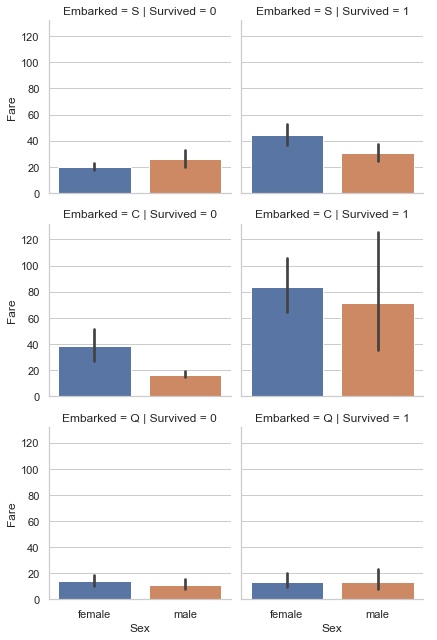

In [13]:
grid = sns.FacetGrid(train, row = 'Embarked', col = 'Survived')
grid.map(sns.barplot, 'Sex', 'Fare', palette = 'deep')
grid.add_legend()
plt.show()

##### Observations:
- Higher Fare paying passengers had better chance at survival. It correlates with the Pclass assumption.
- Point of Embark has an effect of Survival.

#### Steps to be taken further:
1. Create a new feature called Family based on Parch and SibSp to get total count of family members on board.
2. Engineer the Name feature to extract Title as a new feature.
3. Create new feature for Age bands. This turns a continous numerical feature into an ordinal categorical feature.
4. Create a Fare range feature to see if it helps the analysis.

##### After doing the feature engineering, we will drop the following features:
- Ticket, Name and Passenger ID because they don't contribute to the survival.
- Cabin as it contains more than 75% missing values.

#### Feature Engineering

#### Creating Titles from the Name feature

In [14]:
for i in combined:
    i['Title'] = i['Name'].apply(lambda x: x.split(', ')[1].split('.')[0])

In [15]:
display(pd.crosstab(train['Title'], train['Sex']))

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40
Miss,182,0


In [16]:
display(train[(train['Title'] == 'Mlle') | (train['Title'] == 'Mme')])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
369,370,1,1,"Aubart, Mme. Leontine Pauline",female,24.0,0,0,PC 17477,69.3000,B35,C,Mme
641,642,1,1,"Sagesser, Mlle. Emma",female,24.0,0,0,PC 17477,69.3000,B35,C,Mlle
710,711,1,1,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",female,24.0,0,0,PC 17482,49.5042,C90,C,Mlle


In [17]:
display(pd.crosstab(test['Title'], test['Sex']))

Sex,female,male
Title,,
Col,0,2
Dona,1,0
Dr,0,1
Master,0,21
Miss,78,0
Mr,0,240
Mrs,72,0
Ms,1,0
Rev,0,2


In [18]:
for i in combined:
    i['Title'] = i['Title'].replace(['Capt', 'Col', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady', \
                                     'Major', 'Rev', 'Sir', 'the Countess'], 'Rare')
    i['Title'] = i['Title'].replace(['Mlle', 'Mme', 'Ms'], 'Miss')

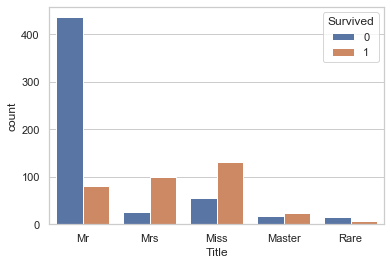

In [19]:
sns.countplot('Title', hue = 'Survived', data = train)
plt.show()

In [20]:
display(train.groupby('Title')['Age'].mean())

Title
Master     4.574167
Miss      21.860000
Mr        32.368090
Mrs       35.898148
Rare      45.545455
Name: Age, dtype: float64

##### Observations:
- The Titles give us clear distinction between age groups. For example, Master is a title having male infants.
- Rare is a title having mean age around 45 years
- Single females have a mean age of 21.8 while married females have mean age of 35.

In [21]:
train = train.drop(['Name', 'PassengerId', 'Ticket', 'Cabin'], axis = 1)
test = test.drop(['Name', 'Ticket', 'Cabin'], axis = 1)
combined = [train, test]
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

Train Shape: (891, 9)
Test Shape: (418, 9)


In [22]:
display(train.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


In [23]:
display(test.head())

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,male,34.5,0,0,7.8292,Q,Mr
1,893,3,female,47.0,1,0,7.0000,S,Mrs
2,894,2,male,62.0,0,0,9.6875,Q,Mr
3,895,3,male,27.0,0,0,8.6625,S,Mr
4,896,3,female,22.0,1,1,12.2875,S,Mrs


##### Converting Sex values to 0 / 1:

In [24]:
for dataset in combined:
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

#### Filling Missing Values for Age Column

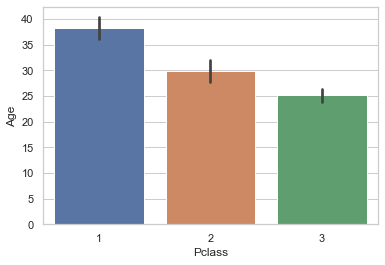

In [25]:
sns.barplot('Pclass', 'Age', data = train)
plt.show()

- A clear relation between Age and Pclass. Upper Class have people with higher average age.

- We can fill the age values using the Pclass and Titles information as both have a distinct relation with Age.

In [26]:
for i in combined:
    i['Age'] = i.groupby(['Pclass', 'Title'])['Age'].apply(lambda x : x.fillna(x.median()))

In [27]:
print(train['Age'].isna().sum())
print(test['Age'].isna().sum())

0
0


- No more missing values in Age Column

#### Creating Age Bands

In [28]:
bins = [0, 5, 15, 30, 50, 80]
for i in combined:
    i['Age'] = pd.cut(i['Age'], bins = bins, labels = [0, 1, 2, 3, 4])

In [29]:
display(train.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,1,2,1,0,7.2500,S,Mr
1,1,1,0,3,1,0,71.2833,C,Mrs
2,1,3,0,2,0,0,7.9250,S,Miss
3,1,1,0,3,1,0,53.1000,S,Mrs
4,0,3,1,3,0,0,8.0500,S,Mr


#### Creating Family Size from SibSp and Parch features
1 - Singles, 2-4: Small Family, >4: Large Family

In [30]:
for i in combined:
    i["Family"] = i["SibSp"] + i["Parch"]

In [31]:
display(train.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family
0,0,3,1,2,1,0,7.2500,S,Mr,1
1,1,1,0,3,1,0,71.2833,C,Mrs,1
2,1,3,0,2,0,0,7.9250,S,Miss,0
3,1,1,0,3,1,0,53.1000,S,Mrs,1
4,0,3,1,3,0,0,8.0500,S,Mr,0


In [32]:
for i in combined:
    i.drop(['Parch', 'SibSp'], 1, inplace = True)

#### Filling Missing values of Embarked column with most Frequent Value

In [33]:
for i in combined:
    i['Embarked'] = i['Embarked'].fillna(i['Embarked'].mode()[0])

#### Filling Missing value in Fare column by Median

In [34]:
for i in combined:
    i['Fare'] = i['Fare'].fillna(i['Fare'].mode()[0])

##### Checking for missing values to confirm

In [35]:
print("Missing Values in Train:",train.isna().sum().sum(),'\nMissing values in Test:', test.isna().sum().sum())

Missing Values in Train: 0 
Missing values in Test: 0


#### Creating Fare Bands

In [36]:
for i in combined:
    i['Fare'] = pd.qcut(i['Fare'], q = 4, labels = [0, 1, 2, 3])

#### Checking Datatypes before modeling

In [37]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int32
Age         891 non-null category
Fare        891 non-null category
Embarked    891 non-null object
Title       891 non-null object
Family      891 non-null int64
dtypes: category(2), int32(1), int64(3), object(2)
memory usage: 40.5+ KB
None


##### Age and Fare must be converted to int

In [38]:
for i in combined:
    i['Age'] = i['Age'].astype(int)
    i['Fare'] = i['Fare'].astype(int)

In [39]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int32
Age         891 non-null int32
Fare        891 non-null int32
Embarked    891 non-null object
Title       891 non-null object
Family      891 non-null int64
dtypes: int32(3), int64(3), object(2)
memory usage: 45.4+ KB
None


#### Converting Categorical Variables into Dummies

In [40]:
train = pd.get_dummies(train, drop_first = True)
test = pd.get_dummies(test, drop_first = True)

In [41]:
display(train.head())

,Survived,Pclass,Sex,Age,Fare,Family,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,3,1,2,0,1,0,1,0,1,0,0
1,1,1,0,3,3,1,0,0,0,0,1,0
2,1,3,0,2,1,0,0,1,1,0,0,0
3,1,1,0,3,3,1,0,1,0,0,1,0
4,0,3,1,3,1,0,0,1,0,1,0,0


In [42]:
display(test.head())

,PassengerId,Pclass,Sex,Age,Fare,Family,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,892,3,1,3,0,0,1,0,0,1,0,0
1,893,3,0,3,0,1,0,1,0,0,1,0
2,894,2,1,4,1,0,1,0,0,1,0,0
3,895,3,1,2,1,0,0,1,0,1,0,0
4,896,3,0,2,1,2,0,1,0,0,1,0


### Separating data into X and Y Variables

In [43]:
X_train = train.drop("Survived", axis = 1)
y_train = train["Survived"]
X_test  = test.drop("PassengerId", axis = 1)
print(X_train.shape, y_train.shape, X_test.shape)

(891, 11) (891,) (418, 11)


In [44]:
acc = {}

### Logistic Regression

In [45]:
lr = LogisticRegression(solver = 'liblinear', random_state = 0)

lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_train_prob = lr.predict_proba(X_train)[:, 1]

acc['LogReg'] = accuracy_score(y_train, y_train_pred)
print(acc['LogReg'])

print('AUC - Train', roc_auc_score(y_train, y_train_prob))

coef_df = pd.DataFrame(lr.coef_, columns = X_train.columns)
display(coef_df)

0.8260381593714927
AUC - Train 0.8772276014870205


,Pclass,Sex,Age,Fare,Family,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,-0.669618,-0.143263,-0.397391,0.464193,-0.504018,0.110169,-0.286141,0.543314,-2.086739,1.163908,-1.445345


#### Observations:
- As the Pclass increases i.e. Socio-economic status reduces, the probability of Survival reduces drastically
- As the Sex goes from 0 to 1 i.e. changes from female to male, the probability of survival reduces.
- As the Age increases, the probability of Survival reduces.
- As the Fare increases, the probability of survival increases by good amount.
- As Family Size increases, probability of survival reduces.
- As the title changes to Mrs or Miss, the probability of Survival increases
- As the title changes to Mr or Rare, the probability of Survival reduces.
- Probabilty of Survival reduces if the person embarked from Southampton.

- Sex is the most important factor in predicting Survival. i.e. Women were given preference while evacuating passengers.
- Pclass and Fare are the second most important factors in predicting survival i.e. Upper class people who paid high fares were given preference while evacuating passengers.
- Age is the third most important factor in predicting Survival i.e. children were given preference while evacuating passengers.

### Decision Tree

In [46]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train, y_train)

y_train_pred = dt.predict(X_train)
y_train_prob = dt.predict_proba(X_train)[:, 1]

print("Accuracy on Train:", accuracy_score(y_train, y_train_pred))
print("AUC on Train:", roc_auc_score(y_train, y_train_prob))

Accuracy on Train: 0.8888888888888888
AUC on Train: 0.9550671609199075


#### Tuning Decision Tree

In [47]:
dt = DecisionTreeClassifier(random_state = 0)

params = {'max_depth' : sp_randint(2, 10),
         'min_samples_split' : sp_randint(2, 10),
          'min_samples_leaf' : sp_randint(1, 10)}

rsearch = RandomizedSearchCV(dt, param_distributions = params,
                            n_iter = 100, cv = 10, scoring = 'accuracy',
                            random_state = 0, n_jobs = -1)
rsearch.fit(X_train, y_train)
print(rsearch.best_params_)

{'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 7}


##### Tuned Decision Tree

In [48]:
dt = DecisionTreeClassifier(**rsearch.best_params_, random_state = 0)
dt.fit(X_train, y_train)

y_train_pred = dt.predict(X_train)
y_train_prob = dt.predict_proba(X_train)[:, 1]
acc['DT'] = accuracy_score(y_train, y_train_pred)
print(acc['DT'])
print("AUC on Train:", roc_auc_score(y_train, y_train_prob))

0.8237934904601572
AUC on Train: 0.8644664941041127


### Random Forest

In [49]:
rf = RandomForestClassifier(random_state = 0)

rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_train_prob = rf.predict_proba(X_train)[:, 1]

print('Confusion Matrix Train \n', confusion_matrix(y_train, y_train_pred))
print("Accuracy on Train:", accuracy_score(y_train, y_train_pred))
print("AUC on Train:", roc_auc_score(y_train, y_train_prob))

Confusion Matrix Train 
 [[514  35]
 [ 64 278]]
Accuracy on Train: 0.8888888888888888
AUC on Train: 0.9491552956465238


#### Tuning Random Forest

In [50]:
rf = RandomForestClassifier(random_state = 0)

params = {'n_estimators' : sp_randint(50, 200),
         'max_features' : sp_randint(1, 10),
         'max_depth' : sp_randint(2, 10),
         'min_samples_leaf' : sp_randint(1, 10),
         'min_samples_split' : sp_randint(2, 10),
         'oob_score' : [False, True]}

rsearch = RandomizedSearchCV(rf, param_distributions = params,
                             scoring = 'accuracy', n_iter = 100,
                            cv = 10, random_state = 0, n_jobs = -1)
rsearch.fit(X_train, y_train)
print(rsearch.best_params_)

{'max_depth': 7, 'max_features': 4, 'min_samples_leaf': 7, 'min_samples_split': 6, 'n_estimators': 121, 'oob_score': True}


##### Tuned Random Forest

In [51]:
rf = RandomForestClassifier(**rsearch.best_params_, random_state = 0)

rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_train_prob = rf.predict_proba(X_train)[:, 1]

acc['RF'] = accuracy_score(y_train, y_train_pred)
print(acc['RF'])
print("AUC on Train:", roc_auc_score(y_train, y_train_prob))

0.8451178451178452
AUC on Train: 0.9036445850509698


In [52]:
imp = pd.DataFrame(rf.feature_importances_, index = X_train.columns, columns = ['Importance'])
display(imp.sort_values(by = 'Importance', ascending = False))

,Importance
Title_Mr,0.258355
Sex,0.242361
Pclass,0.152904
Family,0.093574
Title_Mrs,0.060582
Fare,0.056407
Age,0.047384
Title_Miss,0.045955
Embarked_S,0.021493
Title_Rare,0.015395


- We can see that Sex is the most important factor in predicting survival followed by Pclass, Family, Fare and Age.

### KNN

In [53]:
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)

y_train_pred = knn.predict(X_train)
y_train_prob = knn.predict_proba(X_train)[:, 1]

print("Accuracy on Train:", accuracy_score(y_train, y_train_pred))
print("AUC on Train:", roc_auc_score(y_train, y_train_prob))

Accuracy on Train: 0.8518518518518519
AUC on Train: 0.908555161431204


#### Tuning KNN

In [54]:
knn = KNeighborsClassifier()
params = {'n_neighbors' : sp_randint(1, 50),
         'p' : sp_randint(1, 7)}

rsearch = RandomizedSearchCV(knn, param_distributions = params, cv = 10, 
                             scoring = 'accuracy', n_iter = 100, random_state = 0, n_jobs = -1)
rsearch.fit(X_train, y_train)
print(rsearch.best_params_)

{'n_neighbors': 9, 'p': 4}


##### Tuned KNN

In [55]:
knn = KNeighborsClassifier(**rsearch.best_params_)

knn.fit(X_train, y_train)

y_train_pred = knn.predict(X_train)
y_train_prob = knn.predict_proba(X_train)[:, 1]
acc['KNN'] = accuracy_score(y_train, y_train_pred)
print(acc['KNN'])
print("AUC on Train:", roc_auc_score(y_train, y_train_prob))

0.8439955106621774
AUC on Train: 0.9085551614312039


### Naive Bayes

In [56]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

y_train_pred = mnb.predict(X_train)
y_train_prob = mnb.predict_proba(X_train)[:, 1]

acc['NB'] = accuracy_score(y_train, y_train_pred)
print(acc['NB'])
print("AUC on Train:", roc_auc_score(y_train, y_train_prob))

0.7845117845117845
AUC on Train: 0.8302149575517421


### AdaBoost

In [57]:
ada = AdaBoostClassifier(random_state = 0)
ada.fit(X_train, y_train)

y_train_pred = ada.predict(X_train)
y_train_prob = ada.predict_proba(X_train)[:, 1]

print('Confusion Matrix Train \n', confusion_matrix(y_train, y_train_pred))
print("Accuracy on Train:", accuracy_score(y_train, y_train_pred))
print("AUC on Train:", roc_auc_score(y_train, y_train_prob))

Confusion Matrix Train 
 [[465  84]
 [ 80 262]]
Accuracy on Train: 0.8159371492704826
AUC on Train: 0.8841460816583048


#### Tuning AdaBoost

In [58]:
ada = AdaBoostClassifier(random_state = 0)
params = {'n_estimators' : sp_randint(25, 100),
         'learning_rate' : np.logspace(-0.5, 0.5, 100)}

rsearch = RandomizedSearchCV(ada, param_distributions = params, cv = 10, 
                             scoring = 'accuracy', n_iter = 100, random_state = 0, n_jobs = -1)
rsearch.fit(X_train, y_train)
print(rsearch.best_params_)

{'learning_rate': 0.4084238652674521, 'n_estimators': 27}


##### Tuned AdaBoost

In [59]:
ada = AdaBoostClassifier(**rsearch.best_params_, random_state = 0)

ada.fit(X_train, y_train)

y_train_pred = ada.predict(X_train)
y_train_prob = ada.predict_proba(X_train)[:, 1]
acc['Ada'] = accuracy_score(y_train, y_train_pred)
print(acc['Ada'])
print("AUC on Train:", roc_auc_score(y_train, y_train_prob))

0.8282828282828283
AUC on Train: 0.876234301600997


### LightGBM

In [60]:
lgbc = lgb.LGBMClassifier(random_state = 0)

lgbc.fit(X_train, y_train)

y_train_pred = lgbc.predict(X_train)
y_train_prob = lgbc.predict_proba(X_train)[:, 1]

print('Confusion Matrix Train \n', confusion_matrix(y_train, y_train_pred))
print("Accuracy on Train:", accuracy_score(y_train, y_train_pred))
print("AUC on Train:", roc_auc_score(y_train, y_train_prob))

Confusion Matrix Train 
 [[507  42]
 [ 71 271]]
Accuracy on Train: 0.8731762065095399
AUC on Train: 0.9358269687576561


#### Tuning LightGBM

In [61]:
lgbc = lgb.LGBMClassifier(random_state = 0)

params = {'n_estimators' : sp_randint(50, 200),
         'max_depth' : sp_randint(1, 20),
         'learning_rate' : sp_uniform(0, 1.5)}

rsearch_lgbm = RandomizedSearchCV(lgbc, param_distributions = params,
                                 cv = 10, n_iter = 100, n_jobs = -1,
                                 scoring = 'accuracy', random_state = 0)

rsearch_lgbm.fit(X_train, y_train)
print(rsearch_lgbm.best_params_)

{'learning_rate': 0.03849407708179736, 'max_depth': 8, 'n_estimators': 111}


##### Tuned LightGBM

In [62]:
lgbc = lgb.LGBMClassifier(**rsearch_lgbm.best_params_, random_state = 0)

lgbc.fit(X_train, y_train)

y_train_pred = lgbc.predict(X_train)
y_train_prob = lgbc.predict_proba(X_train)[:, 1]

acc['LGBM'] = accuracy_score(y_train, y_train_pred)
print(acc['LGBM'])
print("AUC on Train:", roc_auc_score(y_train, y_train_prob))

0.8597081930415263
AUC on Train: 0.9215266460017683


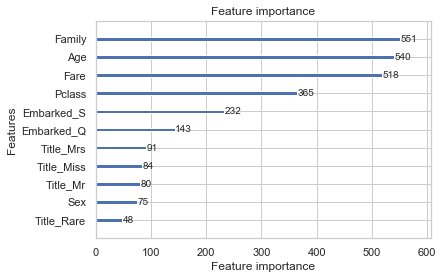

In [63]:
lgb.plot_importance(lgbc)
plt.show()

### Stacking

In [64]:
print(acc)

{'LogReg': 0.8260381593714927, 'DT': 0.8237934904601572, 'RF': 0.8451178451178452, 'KNN': 0.8439955106621774, 'NB': 0.7845117845117845, 'Ada': 0.8282828282828283, 'LGBM': 0.8597081930415263}


#### Voting Classifier

In [76]:
clf = VotingClassifier(estimators = [('knn', knn), ('rf', rf), 
                                     ('lgbc', lgbc)], 
                       voting = 'soft')
#soft = takes average of the probabilities, then predict values
#Here we have taken weighted average
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
#y_train_prob = clf.predict_proba(X_train)[:, 1]

print("Accuracy on Train:", accuracy_score(y_train, y_train_pred))
#print("AUC on Train:", roc_auc_score(y_train, y_train_prob))

Accuracy on Train: 0.8529741863075196


#### Preparing the data for submission

In [77]:
y_test_pred = clf.predict(X_test)

solution = pd.DataFrame({'PassengerId' : test['PassengerId'], 'Survived' : y_test_pred})

# Export to CSV
solution.to_csv("Solution7_Titanic_VotSoft_KnnRfLgbc_Saurabh.csv", index = False)

solution.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
